# Inside Airbnb London (UK) Data Analysis

## Business Understanding

Inside Airbnb is an independent, non-commercial set of tools and data that allows us to explore how Airbnb (a short-term accommodation marketplace connecting tourists and tenants with residential home owners) is really being used in cities around the world.

Here we will analyse data on London in an attempt to discover:

1. How do the different neighborhoods typically compare in price?
2. How do the different neighborhoods typically compare in number of reviews per month?
3. What else is typically important for getting more reviews per month (i.e. the top 5 influential features)?

To answer these questions we will fit one regression model to describe the relationship between a selection of listings' features and the price, and one to describe the relationship between listings' features and the rate of reviews posted (which will serve as a proxy for the number of bookings, in the absence of this information).

Given the effect that the coronavirus pandemic has had on travel and hospitality in 2020, we analyse pre-2020 data only.

Only listings which have at least one review and a price above zero will be analysed, to avoid a potentially large number of unbooked listings to influence the findings.

## Data Understanding

Inside Airbnb provides `listings.csv` which contains details for each listed accommodation in London, including neighborhood, price, number of reviews and average rating, and whether the host is a superhost, amongst many other features.

In [1]:
# python 3.8.5

import numpy as np # 1.20.1
import pandas as pd # 1.2.4
import matplotlib.pyplot as plt # 3.3.4
import statsmodels.api as sm # 0.12.2
import re

pd.set_option("max_columns", None)
pd.set_option("max_rows", 75)
%matplotlib inline

In [2]:
listings = pd.read_csv('listings.csv')

In [3]:
listings.shape

(77136, 74)

We have 77,136 records, and 74 features.

In [4]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,90%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",$105.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,100%,75%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",$40.00,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,100%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",$75.00,10,50,10.0,10.0,50.0,50.0,10.0,50.0,

Looking at the contents of the columns, there are many included which won't help us answer the questions of concern (or else other similar columns will be more useful), so these columns can be dropped.

In [5]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [6]:
listings.drop(
    ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
     'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
     'host_name', 'host_since', 'host_location', 'host_about',
     'host_response_rate', 'host_acceptance_rate',
     'host_thumbnail_url', 'host_picture_url',
     'host_neighbourhood', 'host_listings_count',
     'host_total_listings_count', 'host_verifications',
     'host_identity_verified', 'neighbourhood',
     'neighbourhood_group_cleansed', 'latitude',
     'longitude', 'property_type', 'bathrooms',
     'bathrooms_text', 'bedrooms', 'beds', 'amenities',
     'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
     'maximum_minimum_nights', 'minimum_maximum_nights',
     'maximum_maximum_nights', 
     'calendar_updated', 'has_availability',
     'availability_30', 'availability_60', 'availability_90',
     'availability_365', 'calendar_last_scraped',
     'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
     'last_review', 'review_scores_accuracy',
     'review_scores_cleanliness', 'review_scores_checkin',
     'review_scores_communication', 'review_scores_location',
     'review_scores_value', 'license',
     'calculated_host_listings_count',
     'calculated_host_listings_count_entire_homes',
     'calculated_host_listings_count_private_rooms',
     'calculated_host_listings_count_shared_rooms'], 
    axis=1, inplace=True)

We look in more detail at the remaining columns while preparing the data.

## Prepare data

First we check how many listings have no reviews, and drop these from the analysis, so that findings are based on listings which have definitely been booked.

In [7]:
len(listings[listings['reviews_per_month'].isna()])

22431

In [8]:
listings.drop(listings[listings['reviews_per_month'].isna()].index, inplace=True)
len(listings[listings['reviews_per_month'].isna()])

0

We do the same for those with zero price.

In [9]:
len(listings[listings['price'] == '$0.00'])

1

In [10]:
listings.drop(listings[listings['price'] == '$0.00'].index, inplace=True)
len(listings[listings['price'] == '$0.00'])

0

Now we check to see how much data is missing.

In [11]:
listings.isna().sum().sort_values(ascending=False)

host_response_time        27152
review_scores_rating       1740
host_is_superhost            30
host_has_profile_pic         30
neighbourhood_cleansed        0
room_type                     0
accommodates                  0
price                         0
minimum_nights_avg_ntm        0
maximum_nights_avg_ntm        0
number_of_reviews             0
instant_bookable              0
reviews_per_month             0
dtype: int64

We won't be able to deduce missing `review_scores_rating` reliably, so we'll drop those listings from the analysis.

In [12]:
listings.drop(listings[listings['review_scores_rating'].isna()].index, inplace=True)
len(listings[listings['review_scores_rating'].isna()])

0

We'll work through the columns and deal with the other missing values as we go.

### Price

First we'll look at the two dependent features our models will analyse, beginning with `price`. From the table head above, it seems the data in this column always begins with `$`, but we check to make sure.

In [13]:
# check its safe to drop first char
listings['price'].str[0:1].unique()

array(['$'], dtype=object)

With that confirmed, we reformat the string price as a float, slicing off the first character `$` and removing any commas.

In [14]:
listings['price_flt'] = listings['price'].str.replace(',', '', regex=False).str.slice(1).astype('float')

We take a look at the distribution of prices.

In [15]:
listings['price_flt'].describe()

count    52964.000000
mean       112.213958
std        397.061512
min          8.000000
25%         44.000000
50%         75.000000
75%        120.000000
max      18175.000000
Name: price_flt, dtype: float64

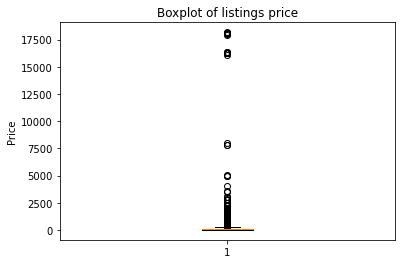

In [16]:
plt.boxplot(listings['price_flt'])
plt.title('Boxplot of listings price')
plt.ylabel('Price');

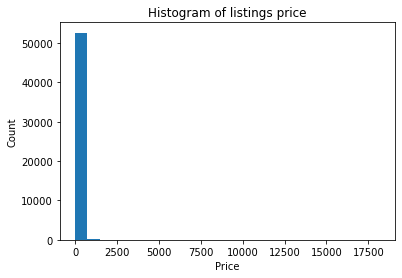

In [17]:
plt.hist(listings['price_flt'],25)
plt.title('Histogram of listings price')
plt.xlabel('Price')
plt.ylabel('Count');

Given that the distribution is left-bounded above zero and heavily right skew, a log transformation is appropriate. Log base 2 is nicely interpretable (an increase of 1 means the price doubles), so we will try this, creating a new column to hold the transformed feature.

In [18]:
listings['log2_price'] = np.log2(listings['price_flt'])

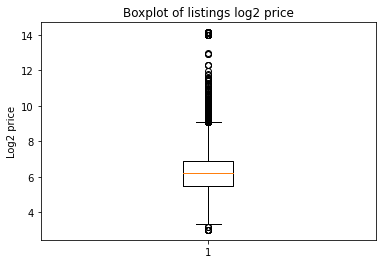

In [19]:
plt.boxplot(listings['log2_price'])
plt.title('Boxplot of listings log2 price')
plt.ylabel('Log2 price');

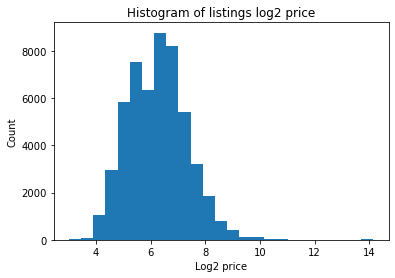

In [20]:
plt.hist(listings['log2_price'],25)
plt.title('Histogram of listings log2 price')
plt.xlabel('Log2 price')
plt.ylabel('Count');

Even after the log transformation there are still some remarkably expensive listings. We take a look at some of the most expensive to make sure they are legitimate listings.

In [21]:
listings[listings['price_flt'] > 10000]

,host_response_time,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,room_type,accommodates,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,price_flt,log2_price
9837,within a few hours,f,t,Islington,Entire home/apt,6,"$16,279.00",1.0,28.0,37,95.0,t,0.58,16279.0,13.990724
9838,within a few hours,f,t,Islington,Entire home/apt,4,"$16,279.00",1.0,28.0,20,90.0,t,0.31,16279.0,13.990724
11761,within a few hours,f,t,Islington,Entire home/apt,4,"$18,088.00",1.0,28.0,20,89.0,t,0.33,18088.0,14.142745
11762,within a few hours,f,t,Islington,Entire home/apt,6,"$16,279.00",1.0,28.0,19,95.0,t,0.34,16279.0,13.990724
11763,within a few hours,f,t,Islington,Entire home/apt,6,"$16,279.00",1.0,28.0,32,96.0,t,0.53,16279.0,13.990724
20508,within a few hours,f,t,Islington,Entire home/apt,4,"$16,307.00",1.0,28.0,13,91.0,t,0.27,16307.0,13.993204
20509,within a few hours,f,t,Islington,Entire home/apt,4,"$16,306.00",1.0,28.0,34,94.0,t,0.70,16306.0,13.993115
21053,within a few hours,f,t,City of London,Entire home/apt,4,"$16,279.00",1.0,28.0,85,95.0,t,1.76,16279.0,13.990724
21929,within a few hours,f,t,City of London,Entire home/apt,4,"$16,350.00",1.0,28.0,61,91.0,t,1.30,16350.0,13.997003
25076,within a day,f,t,Westminster,Entire home/apt,4,"$17,912.00",1.0,28.0,7,97.0,t,0.17,17912.0,14.128639


The listings look legitimate, but the prices are not typical of airbnb listings and may exert undue influence on the regression. We will include them in the analysis for now and review the effects of this on the regression result.

### Reviews per month

Next we take a look at the distribution of `reviews_per_month`.

In [22]:
listings['reviews_per_month'].describe()

count    52964.000000
mean         0.626359
std          0.873644
min          0.010000
25%          0.120000
50%          0.330000
75%          0.800000
max         36.830000
Name: reviews_per_month, dtype: float64

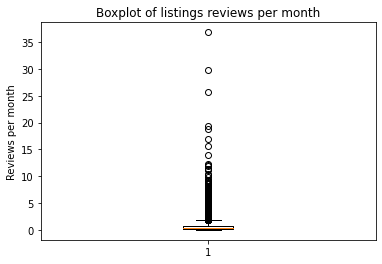

In [23]:
plt.boxplot(listings['reviews_per_month'])
plt.title('Boxplot of listings reviews per month')
plt.ylabel('Reviews per month');

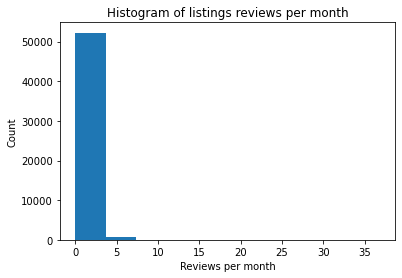

In [24]:
plt.hist(listings['reviews_per_month'])
plt.title('Histogram of listings reviews per month')
plt.xlabel('Reviews per month')
plt.ylabel('Count');

Given that the distribution is also left-bounded above zero and heavily right skew, a log transformation is again appropriate. Log base 2 is nicely interpretable (an increase of 1 means the number of reviews per month doubles), so we will try this, creating a new column to hold the transformed feature.

In [25]:
listings['log2_reviews_per_month'] = np.log2(listings['reviews_per_month'])

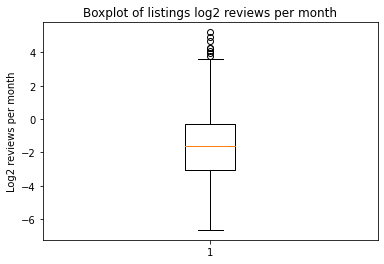

In [26]:
plt.boxplot(listings['log2_reviews_per_month'])
plt.title('Boxplot of listings log2 reviews per month')
plt.ylabel('Log2 reviews per month');

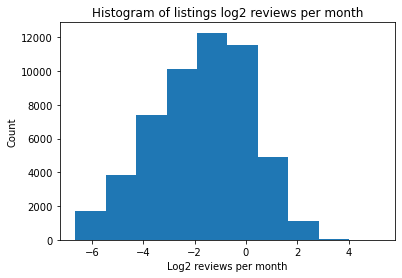

In [27]:
plt.hist(listings['log2_reviews_per_month'])
plt.title('Histogram of listings log2 reviews per month')
plt.xlabel('Log2 reviews per month')
plt.ylabel('Count');

There are a small minority of listings getting large numbers of reviews per month - in some cases more than one per day - which seems unlikely for single units of accommodation. These listings seem like potential outliers, exhibiting very different behaviour to the vast majority of listings, so we take a look at some of them.

In [28]:
listings[listings['reviews_per_month'] > 10]

,host_response_time,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,room_type,accommodates,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,price_flt,log2_price,log2_reviews_per_month
869,within a day,f,t,Lambeth,Entire home/apt,8,$61.00,14.0,1125.0,180,97.0,f,11.23,61.0,5.930737,3.489286
10691,NaN,t,t,Hillingdon,Private room,2,$35.00,1.0,1125.0,711,97.0,f,11.35,35.0,5.129283,3.504620
26649,within a few hours,t,t,Tower Hamlets,Entire home/apt,2,$100.00,1.0,8.5,614,96.0,t,19.41,100.0,6.643856,4.278728
30244,within an hour,f,t,Hillingdon,Private room,2,$25.00,1.0,1125.0,441,91.0,t,11.35,25.0,4.643856,3.504620
30345,within an hour,f,t,Hillingdon,Private room,1,$22.00,1.0,1125.0,478,94.0,t,12.30,22.0,4.459432,3.620586
33561,within an hour,f,t,Westminster,Hotel room,2,$95.00,1.0,1002.4,413,92.0,t,12.04,95.0,6.569856,3.589763
53560,within a few hours,f,t,Camden,Hotel room,1,$19.00,1.0,1048.3,184,83.0,t,10.51,19.0,4.247928,3.393691
66083,within an hour,t,t,City of London,Entire home/apt,2,$86.00,1.0,33.0,260,97.0,t,25.66,86.0,6.426265,4.681449
66087,within an hour,t,t,City of London,Entire home/apt,2,$95.00,1.0,30.5,94,95.0,t,10.18,95.0,6.569856,3.347666
68250,within an hour,f,t,Lambeth,Private room,2,$67.00,1.0,31.0,62,90.0,t,16.91,67.0,6.066089,4.079805


While its possible that these are unusually extremely successful listings, the extremely high numbers of reviews seem suspicious, or at the very least not typical of airbnb listings, and they may exert undue influence on the regression. We will include them in the analysis for now and review the effects of this on the regression result.

### Host response time

We check the value counts.

In [29]:
listings['host_response_time'].value_counts(dropna=False)

NaN                   25701
within an hour        14702
within a few hours     5738
within a day           4831
a few days or more     1992
Name: host_response_time, dtype: int64

This feature will be one-hot-encoded. `NaN` here indicates the host hasn't responded to anything (whether because they haven't been asked, we can't tell) and is most frequent, so this will serve as the baseline, with other options being allocated a column.

First we rename the options to remove spaces.

In [30]:
listings['host_response_time'] = listings['host_response_time'].str.replace(' ', '_')

In [31]:
listings['host_response_time'].value_counts(dropna=False)

NaN                   25701
within_an_hour        14702
within_a_few_hours     5738
within_a_day           4831
a_few_days_or_more     1992
Name: host_response_time, dtype: int64

Next we create the dummies.

In [32]:
listings = listings.join(pd.get_dummies(listings['host_response_time'], prefix='responds'))

We check it looks as expected.

In [33]:
listings.iloc[0:5, -5:]

,log2_reviews_per_month,responds_a_few_days_or_more,responds_within_a_day,responds_within_a_few_hours,responds_within_an_hour
0,0.545968,0,0,0,1
1,-2.556393,0,0,1,0
2,-0.599462,0,0,0,0
3,-1.514573,1,0,0,0
5,-0.014500,0,0,0,0


### Host is superhost

We check the value counts.

In [34]:
listings['host_is_superhost'].value_counts(dropna=False)

f      42804
t      10131
NaN       29
Name: host_is_superhost, dtype: int64

We simply convert `t`/`f` to 1/0, and assume Nan is equivalent to `f`.

In [35]:
listings['host_is_superhost'] = listings['host_is_superhost'].map({'f':0, 't':1}, na_action='ignore')
listings['host_is_superhost'] = listings['host_is_superhost'].fillna(0).astype(np.uint8)

We check it looks as expected.

In [36]:
listings['host_is_superhost'].value_counts(dropna=False)

0    42833
1    10131
Name: host_is_superhost, dtype: int64

### Host has profile pic

We check the value counts.

In [37]:
listings['host_has_profile_pic'].value_counts(dropna=False)

t      52803
f        132
NaN       29
Name: host_has_profile_pic, dtype: int64

We simply convert `t`/`f` to 1/0, and assume Nan is equivalent to `f`.

In [38]:
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].map({'f':0, 't':1})
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].fillna(0).astype(np.uint8)

We check it looks as expected.

In [39]:
listings['host_has_profile_pic'].value_counts(dropna=False)

1    52803
0      161
Name: host_has_profile_pic, dtype: int64

### Neighborhood cleansed

We check the value counts.

In [40]:
listings['neighbourhood_cleansed'].value_counts()

Westminster               5828
Tower Hamlets             4713
Hackney                   4092
Camden                    3731
Kensington and Chelsea    3571
Islington                 3196
Lambeth                   3169
Southwark                 3149
Wandsworth                2658
Hammersmith and Fulham    2542
Brent                     1603
Lewisham                  1519
Haringey                  1446
Newham                    1209
Ealing                    1136
Greenwich                 1096
Barnet                     990
Waltham Forest             947
Merton                     810
Richmond upon Thames       802
Croydon                    706
Hounslow                   688
Enfield                    438
Hillingdon                 426
Redbridge                  416
Bromley                    404
Kingston upon Thames       372
City of London             298
Harrow                     277
Barking and Dagenham       224
Sutton                     183
Havering                   168
Bexley  

This feature will be one-hot-encoded. `Westminster` is most frequent, so this will serve as the baseline, with other options being allocated a column.

First we rename the options to remove spaces and convert to lower case.

In [41]:
listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].str.replace(' ', '_').str.lower()

In [42]:
neighborhood_counts = listings['neighbourhood_cleansed'].value_counts()
neighborhood_counts

westminster               5828
tower_hamlets             4713
hackney                   4092
camden                    3731
kensington_and_chelsea    3571
islington                 3196
lambeth                   3169
southwark                 3149
wandsworth                2658
hammersmith_and_fulham    2542
brent                     1603
lewisham                  1519
haringey                  1446
newham                    1209
ealing                    1136
greenwich                 1096
barnet                     990
waltham_forest             947
merton                     810
richmond_upon_thames       802
croydon                    706
hounslow                   688
enfield                    438
hillingdon                 426
redbridge                  416
bromley                    404
kingston_upon_thames       372
city_of_london             298
harrow                     277
barking_and_dagenham       224
sutton                     183
havering                   168
bexley  

Next we create the dummies.

In [43]:
listings = listings.join(pd.get_dummies(listings['neighbourhood_cleansed']))

We check it looks as expected.

In [44]:
listings.iloc[0:5, -34:]

,responds_within_an_hour,barking_and_dagenham,barnet,bexley,brent,bromley,camden,city_of_london,croydon,ealing,enfield,greenwich,hackney,hammersmith_and_fulham,haringey,harrow,havering,hillingdon,hounslow,islington,kensington_and_chelsea,kingston_upon_thames,lambeth,lewisham,merton,newham,redbridge,richmond_upon_thames,southwark,sutton,tower_hamlets,waltham_forest,wandsworth,westminster
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Room type

We check the value counts.

In [45]:
listings['room_type'].value_counts()

Entire home/apt    30556
Private room       21703
Hotel room           423
Shared room          282
Name: room_type, dtype: int64

This feature will be one-hot-encoded. `Entire home/apt` is most frequent, so this will serve as the baseline, with other options being allocated a column.

First we rename the options to remove spaces and convert to lower case.

In [46]:
listings['room_type'] = listings['room_type'].str.replace(' ', '_').str.replace('/', '_').str.lower()

In [47]:
listings['room_type'].value_counts()

entire_home_apt    30556
private_room       21703
hotel_room           423
shared_room          282
Name: room_type, dtype: int64

Next we create the dummies.

In [48]:
listings = listings.join(pd.get_dummies(listings['room_type']))

We check it looks as expected.

In [49]:
listings.iloc[0:5, -5:]

,westminster,entire_home_apt,hotel_room,private_room,shared_room
0,0,1,0,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,1,1,0,0,0
5,0,0,0,1,0


### Accommodates

We check the distribution.

In [50]:
listings['accommodates'].value_counts().sort_index()

1      6421
2     22980
3      3589
4     10901
5      2467
6      4015
7       698
8      1110
9       225
10      286
11       46
12      105
13       27
14       23
15       13
16       58
Name: accommodates, dtype: int64

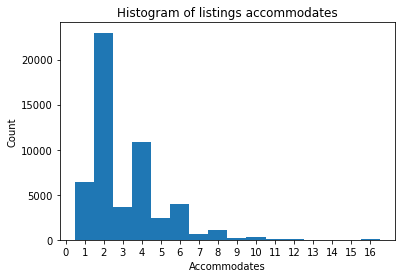

In [51]:
bins = np.arange(0,17) + 0.5
plt.hist(listings['accommodates'], bins)
ticks = np.arange(0,17)
plt.xticks(ticks, ticks)
plt.title('Histogram of listings accommodates')
plt.xlabel('Accommodates')
plt.ylabel('Count');

It seems unlikely that there will be a linear relationship between `accommodated` and `log2_price` or `log2_reviews_per_month`, potentially meaning that each extra person has an increasing effect on the price/number of reviews. We try binning the data to see if there is an effect at any of the levels.

We create a function to handle this as it will be useful later.

In [52]:
def bin_column(col, bins, prefix=None):
    """For each bin, create a column containing a 1 for any listing for which the
    cell value is within the bin range, 0 if not
    
    Args:
    col: Pandas series. Column to bin.
    bins: list. Bin boundaries - bins will be applied as [x, y), [y, z), etc.
    prefix: string. Prefix to use for each column name. Defaults to col.name.

    Returns:
    df: Pandas DataFrame. Dataframe containing columns of binned data.
    """
    
    if not prefix:
        prefix = col.name
    
    df = pd.DataFrame(index=col.index)
    
    for n in range(1, len(bins)):
        # 1 for any listing for which the cell value is within the bin range
        df.loc[(col >= bins[n-1]) & 
               (col < bins[n]), 
               f'{prefix}_{bins[n-1]}_{bins[n]-1}'] = 1
        
        # 0 for any listing for which the cell value is not within the bin range
        df[f'{prefix}_{bins[n-1]}_{bins[n]-1}'] = \
            df[f'{prefix}_{bins[n-1]}_{bins[n]-1}'].fillna(0).astype(np.uint8)
    
    return df

We bin the data. Accommodating one will be taken as the baseline, and columns created for other bins.

In [53]:
# Set bin boundaries
bins = [2, 3, 5, 8, 17]

# Create bin columns
listings = listings.join(bin_column(listings['accommodates'], bins))

We check it looks as expected.

In [54]:
listings.iloc[0:5, -5:]

,shared_room,accommodates_2_2,accommodates_3_4,accommodates_5_7,accommodates_8_16
0,0,0,1,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
5,0,1,0,0,0


### Minimum Nights Avg Ntm

We check the distribution.

In [55]:
listings['minimum_nights_avg_ntm'].describe()

count    52964.000000
mean         5.073780
std         23.811771
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1124.000000
Name: minimum_nights_avg_ntm, dtype: float64

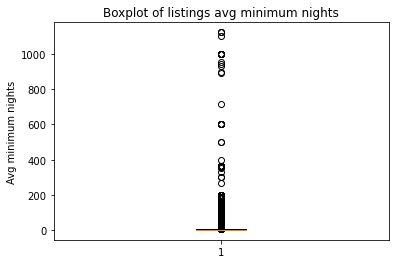

In [56]:
plt.boxplot(listings['minimum_nights_avg_ntm'])
plt.title('Boxplot of listings avg minimum nights')
plt.ylabel('Avg minimum nights');

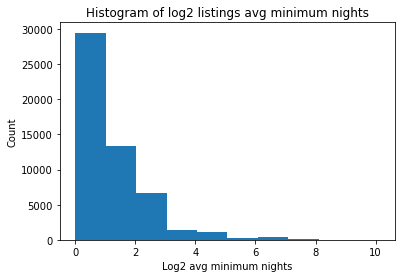

In [57]:
plt.hist(np.log2(listings['minimum_nights_avg_ntm']))
plt.title('Histogram of log2 listings avg minimum nights')
plt.xlabel('Log2 avg minimum nights')
plt.ylabel('Count');

It seems a stretch to assume a linear relationship between `minimum_nights_avg_ntm` and `log2_price` or `log2_reviews_per_month`, but it could be worth binning the data into equivalents of single night, weekend, week, month, quarter, and above (bearing in mind that 90 days is the maximum allowed in London), to see whether there is an effect at any of these levels.

A one-night stay will be taken as the baseline, and columns created for other minimum stay bins.

In [58]:
# Set bin boundaries
bins = [2, 3, 8, 32, 91, 2000]

# Create bin columns
listings = listings.join(bin_column(listings['minimum_nights_avg_ntm'], bins, 'min_nights'))

We check it looks as expected.

In [59]:
listings.iloc[0:5, -6:]

,accommodates_8_16,min_nights_2_2,min_nights_3_7,min_nights_8_31,min_nights_32_90,min_nights_91_1999
0,0,1,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,1,0,0
3,0,0,1,0,0,0
5,0,0,0,1,0,0


### Minimum Nights Avg Ntm

We check the distribution.

In [60]:
listings['maximum_nights_avg_ntm'].describe()

count    5.296400e+04
mean     4.489765e+05
std      2.952240e+07
min      1.000000e+00
25%      9.000000e+01
50%      1.125000e+03
75%      1.125000e+03
max      2.147484e+09
Name: maximum_nights_avg_ntm, dtype: float64

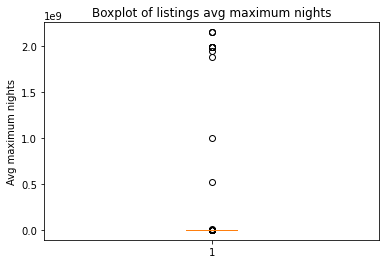

In [61]:
plt.boxplot(listings['maximum_nights_avg_ntm'])
plt.title('Boxplot of listings avg maximum nights')
plt.ylabel('Avg maximum nights');

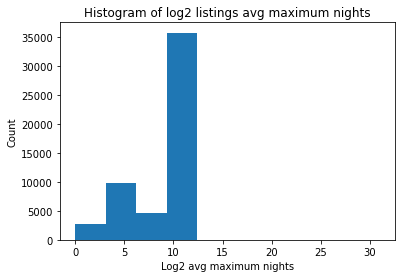

In [62]:
plt.hist(np.log2(listings['maximum_nights_avg_ntm']))
plt.title('Histogram of log2 listings avg maximum nights')
plt.xlabel('Log2 avg maximum nights')
plt.ylabel('Count');

It also seems a stretch to assume a linear relationship between `maximum_nights_avg_ntm` and `log2_price` or `log2_reviews_per_month`, but again it could be worth binning the data into equivalents of single night, weekend, week, month, quarter, and above (bearing in mind that 90 days is the maximum allowed in London), to see whether there is an effect at any of these levels.

A 90+ night stay will be taken as the baseline, and columns created for other minimum stay bins.

In [63]:
# Set bin boundaries
bins = [1, 2, 3, 8, 32, 91]

# Create bin columns
listings = listings.join(bin_column(listings['maximum_nights_avg_ntm'], bins, 'max_nights'))

We check it looks as expected.

In [64]:
listings.iloc[0:5, -6:]

,min_nights_91_1999,max_nights_1_1,max_nights_2_2,max_nights_3_7,max_nights_8_31,max_nights_32_90
0,0,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,0,0,0
5,0,0,0,0,0,0


### Number of reviews

We check the distribution.

In [65]:
listings['number_of_reviews'].describe()

count    52964.000000
mean        22.219734
std         40.934959
min          1.000000
25%          3.000000
50%          8.000000
75%         24.000000
max        817.000000
Name: number_of_reviews, dtype: float64

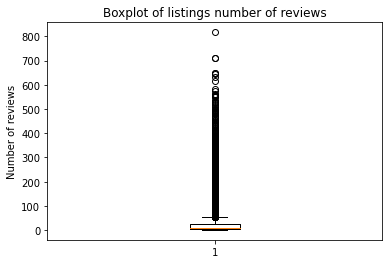

In [66]:
plt.boxplot(listings['number_of_reviews'])
plt.title('Boxplot of listings number of reviews')
plt.ylabel('Number of reviews');

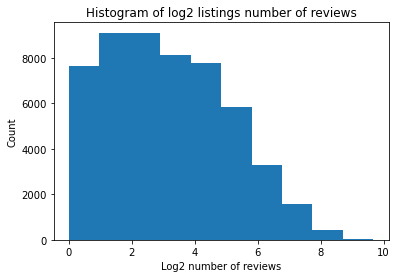

In [67]:
plt.hist(np.log2(listings['number_of_reviews']))
plt.title('Histogram of log2 listings number of reviews')
plt.xlabel('Log2 number of reviews')
plt.ylabel('Count');

It seems unlikely that a linear relationship exists between `number_of_reviews` and `log2_price`, so we try binning the data to see whether there is an effect at any of the levels.

One review will be taken as the baseline, and columns created for other bins.

N.B. this feature won't be included in analysis of `log2_reviews_per_month` because `reviews_per_month` is derived from a close relative of `number_of_reviews`. A seperate analysis would need to be carried out to determine whether the number of reviews at any given point in time affects the expected time until the next review.

In [68]:
# Set bin boundaries
bins = [2, 5, 10, 50, 100, 500, 1000]

# Create bin columns
listings = listings.join(bin_column(listings['number_of_reviews'], bins, 'n_reviews'))

We check it looks as expected.

In [69]:
listings.iloc[0:5, -7:]

,max_nights_32_90,n_reviews_2_4,n_reviews_5_9,n_reviews_10_49,n_reviews_50_99,n_reviews_100_499,n_reviews_500_999
0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0
3,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0


### Review scores rating

We check the distribution.

In [70]:
listings['review_scores_rating'].describe()

count    52964.000000
mean        93.044521
std         10.531513
min         20.000000
25%         90.000000
50%         96.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

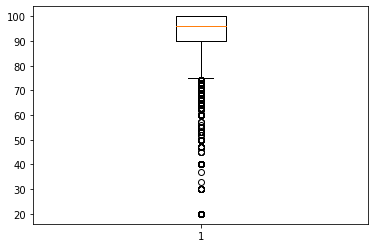

In [71]:
plt.boxplot(listings['review_scores_rating'].dropna());

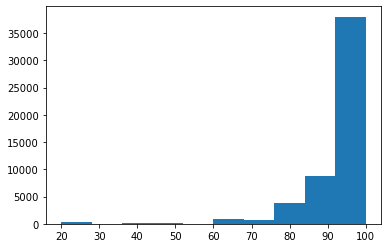

In [72]:
plt.hist(listings['review_scores_rating']);

It also seems a stretch to assume a linear relationship between `review_scores_rating` and `log2_price` or `reviews_per_month`, but again it could be worth binning the data based on quantiles to see whether there is an effect at any of the levels.

First we check the review score at each decile, weighting by `number_of_reviews`.

In [73]:
# Create nested list of average score alongside number of reviews, for each listing
scores_and_nums = zip(listings['review_scores_rating'].values.tolist(),
                           listings['number_of_reviews'].values.tolist())

# Expand to a score for each review, for each listing
scores_expanded = [[x[0]] * x[1] for x in scores_and_nums]

# Flatten and sort ascending
scores = [item for sublist in scores_expanded for item in sublist]
scores.sort()

# Find deciles
score_deciles = []
for x in range(0,10):
    idx = int(len(scores) * x / 10)
    score_deciles.append(int(scores[idx]))
score_deciles.append(int(scores[-1])) 

score_deciles

[20, 88, 91, 93, 94, 96, 97, 97, 98, 99, 100]

Next we bin the scores, and the bin containing the median score (96%) will be taken as the baseline.

In [74]:
# Set bin boundaries
del score_deciles[6]
score_deciles.append(101) # needed as bins will applied as [x,y)

# Create bin columns
listings = listings.join(bin_column(listings['review_scores_rating'], score_deciles, 'score'))

Check it looks as expected.

In [75]:
listings.iloc[0:5, -8:]

,score_91_92,score_93_93,score_94_95,score_96_96,score_97_97,score_98_98,score_99_99,score_100_100
0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0


### Instant bookable

We check the value counts.

In [76]:
listings['instant_bookable'].value_counts()

f    35171
t    17793
Name: instant_bookable, dtype: int64

We simply convert `t`/`f` to 1/0, and assume Nan is equivalent to `f`.

In [77]:
listings['instant_bookable'] = listings['instant_bookable'].map({'f':0, 't':1}, na_action='ignore').astype(np.uint8)

We check it looks as expected.

In [78]:
listings['instant_bookable'].value_counts()

0    35171
1    17793
Name: instant_bookable, dtype: int64

### Drop unnecessary columns

We drop columns that won't be needed for the analysis.

In [79]:
drop_cols = set()

# Drop non-numeric columns which have been processed into new numeric columns
drop_cols.update(['price', 'reviews_per_month'])

# nan host repsonse time will be baseline case so no need to drop another category
drop_cols.update(['host_response_time'])

# Westminster will be baseline case
drop_cols.update(['neighbourhood_cleansed', 'westminster'])

# Entire Home/Apt will be baseline case
drop_cols.update(['room_type', 'entire_home_apt'])

# Average review score 96% will be baseline case
drop_cols.update(['score_96_96'])

# Drop columns which have been transformed/binned into new columns
drop_cols.update(['accommodates', 'price_flt', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews', 'review_scores_rating'])

listings.drop(drop_cols, axis=1, inplace=True)

### Cleaning function

We create a cleaning function to take care of all the above cleaning steps for future use.

In [80]:
def clean_listings(df):
    """Remove listings with NaN reviews_per_month or zero price, one-hot-encode or bin
    other columns, and provide a set of names for any columns which won't be used in the
    analysis.
    
    Args:
    df: Pandas DataFrame. Dataframe containing the listings.

    Returns:
    df: Pandas DataFrame. Dataframe containing the cleaned listings.
    drop_cols: set. The columns to be dropped before analysis.
    """
    
   # Drop df with no reviews
    df.drop(df[df['reviews_per_month'].isna()].index, inplace=True)
    
    # Drop df with zero price
    df.drop(df[df['price'] == '$0.00'].index, inplace=True)
    
    # Convert price to flt and apply log2 transformation
    df['price_flt'] = df['price'].str.replace(',', '', regex=False).str.slice(1).astype('float')
    df['log2_price'] = np.log2(df['price_flt'])
    
    # Apply log2 transformation to reviews_per_month
    df['log2_reviews_per_month'] = np.log2(df['reviews_per_month'])
    
    # One-hot-encode host_repsonse_time
    df['host_response_time'] = df['host_response_time'].str.replace(' ', '_')
    df = df.join(pd.get_dummies(df['host_response_time'], prefix='responds'))
    
    # Re-encode host_is_superhost
    df['host_is_superhost'] = df['host_is_superhost'].map({'f':0, 't':1}, na_action='ignore')
    df['host_is_superhost'] = df['host_is_superhost'].fillna(0).astype(np.uint8)
    
    # Re-encode host_has_profile_pic
    df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'f':0, 't':1})
    df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna(0).astype(np.uint8)
    
    # One-hot_encode neighborhood_cleansed
    df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace(' ', '_').str.lower()
    df = df.join(pd.get_dummies(df['neighbourhood_cleansed']))
    
    # One-hot_encode room_type
    df['room_type'] = df['room_type'].str.replace(' ', '_').str.replace('/', '_').str.lower()
    df = df.join(pd.get_dummies(df['room_type']))
    
    # Bin accommodates
    bins = [2, 3, 5, 8, 17]
    df = df.join(bin_column(df['accommodates'], bins))
    
    # Bin minimum_nights_avg_ntm
    bins = [2, 3, 8, 32, 91, 2000]
    df = df.join(bin_column(df['minimum_nights_avg_ntm'], bins, 'min_nights'))
    
    # Bin maximum_nights_avg_ntm
    bins = [1, 2, 3, 8, 32, 91]
    df = df.join(bin_column(df['maximum_nights_avg_ntm'], bins, 'max_nights'))
    
    # Bin number_of_reviews
    bins = [2, 5, 10, 50, 100, 500, 1000]
    df = df.join(bin_column(df['number_of_reviews'], bins, 'n_reviews'))
    
    # Bin review_scores_rating
    bins = [20, 88, 91, 93, 94, 96, 97, 98, 99, 100, 101]
    df = df.join(bin_column(df['review_scores_rating'], bins, 'score'))
    
    # Re-encode instant_bookable
    df['instant_bookable'] = df['instant_bookable'].map({'f':0, 't':1}, na_action='ignore').astype(np.uint8)
    
    # Drop columns which aren't used at all
    drop_cols = set(
        ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
         'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
         'host_name', 'host_since', 'host_location', 'host_about',
         'host_response_rate', 'host_acceptance_rate',
         'host_thumbnail_url', 'host_picture_url',
         'host_neighbourhood', 'host_listings_count',
         'host_total_listings_count', 'host_verifications',
         'host_identity_verified', 'neighbourhood',
         'neighbourhood_group_cleansed', 'latitude',
         'longitude', 'property_type', 'bathrooms',
         'bathrooms_text', 'bedrooms', 'beds', 'amenities',
         'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
         'maximum_minimum_nights', 'minimum_maximum_nights',
         'maximum_maximum_nights', 
         'calendar_updated', 'has_availability',
         'availability_30', 'availability_60', 'availability_90',
         'availability_365', 'calendar_last_scraped',
         'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
         'last_review', 'review_scores_accuracy',
         'review_scores_cleanliness', 'review_scores_checkin',
         'review_scores_communication', 'review_scores_location',
         'review_scores_value', 'license',
         'calculated_host_listings_count',
         'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms',
         'calculated_host_listings_count_shared_rooms'])

    # Drop non-numeric columns which have been processed into new numeric columns
    drop_cols.update(['price', 'reviews_per_month'])

    # nan host repsonse time will be baseline case so no need to drop another category
    drop_cols.update(['host_response_time'])

    # Westminster will be baseline case
    drop_cols.update(['neighbourhood_cleansed', 'westminster'])

    # Entire Home/Apt will be baseline case
    drop_cols.update(['room_type', 'entire_home_apt'])

    # Average review score 96% will be baseline case
    drop_cols.update(['score_96_96'])

    # Drop columns which have been transformed/binned into new columns
    drop_cols.update(['accommodates', 'price_flt', 'minimum_nights_avg_ntm', 
                      'maximum_nights_avg_ntm', 'number_of_reviews', 'review_scores_rating'])
    
    return df, drop_cols

## Model Data

We move the dependent variables to be the final columns.

In [81]:
# Prepare dataframe for regression
listings = listings[[col for col in listings if col not in ['log2_price', 'log2_reviews_per_month']] + ['log2_price', 'log2_reviews_per_month']]
listings.iloc[0:5, -5:]

,score_98_98,score_99_99,score_100_100,log2_price,log2_reviews_per_month
0,0,0,0,6.714246,0.545968
1,0,0,0,5.321928,-2.556393
2,0,0,0,6.228819,-0.599462
3,0,0,0,8.262095,-1.514573
5,0,0,0,4.857981,-0.014500


### Price regression model

We define X and y for the price regression.

In [82]:
X = listings.columns[:-2].tolist()
y = listings.columns[-2]

We run the regression.

In [83]:
price_model = sm.OLS(listings[y], sm.add_constant(listings[X])).fit()

We look at the summary results and some diagnostic charts.

In [84]:
print(price_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log2_price   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     1179.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:15:10   Log-Likelihood:                -54396.
No. Observations:               52964   AIC:                         1.089e+05
Df Residuals:                   52892   BIC:                         1.096e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

We will streamline the model by stripping out features that don't appear to be significant, but first we look at the distribution of the residuals compared to a normal distribution.

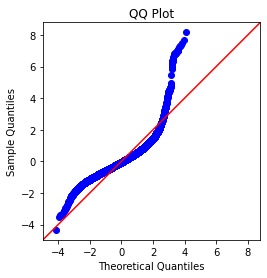

In [85]:
res_price = price_model.resid

fig, ax = plt.subplots()
pplot = sm.ProbPlot(res_price)
pplot.qqplot(ax=ax)
sm.qqline(ax, '45')
plt.title('QQ Plot')
plt.gca().set_aspect('equal', adjustable='box');

The residuals don't appear to follow a normal distribution. However, the residuals between -2 and 2 standard deviations from the mean do appear to follow a normal distribution. It seems to be the extreme cases which throw things off. We investigate further with some more plots.

First comparing the residual errors to a simulated normal distribution with the same parameters.

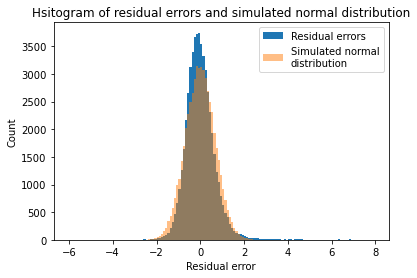

In [86]:
norm_price = np.random.normal(loc=np.mean(res_price), scale=np.std(res_price), size=len(res_price))

bins = np.arange(-6, 8, 0.1)
plt.hist(res_price, bins)
plt.hist(norm_price, bins, alpha=0.5)
plt.title('Hsitogram of residual errors and simulated normal distribution')
plt.legend(['Residual errors', 'Simulated normal\ndistribution'])
plt.xlabel('Residual error')
plt.ylabel('Count');

Interesting to note that the residual errors again appear approximately normal if adjusting the parameters of the simulated distribution to compensate for the extreme values.

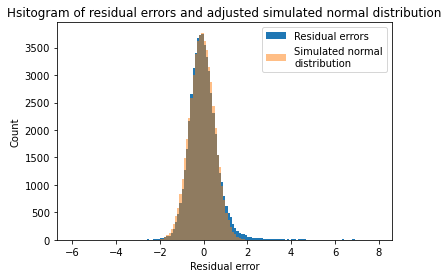

In [87]:
norm_price = np.random.normal(loc=np.mean(res_price)-0.08, scale=0.83*np.std(res_price), size=len(res_price))

bins = np.arange(-6, 8, 0.1)
plt.hist(res_price, bins)
plt.hist(norm_price, bins, alpha=0.5)
plt.title('Hsitogram of residual errors and adjusted simulated normal distribution')
plt.legend(['Residual errors', 'Simulated normal\ndistribution'])
plt.xlabel('Residual error')
plt.ylabel('Count');

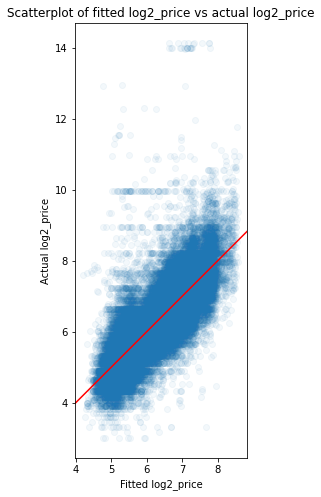

In [88]:
fit_price = price_model.fittedvalues

plt.figure(figsize=(8,8))
plt.scatter(fit_price, listings['log2_price'], alpha=0.05)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'r', scalex=False, scaley=False)
plt.title('Scatterplot of fitted log2_price vs actual log2_price')
plt.xlabel('Fitted log2_price')
plt.ylabel('Actual log2_price')
plt.gca().set_aspect('equal', adjustable='box');

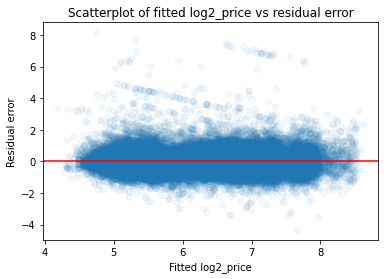

In [89]:
plt.scatter(fit_price, res_price, alpha=0.05)
xpoints = plt.xlim()
plt.plot(xpoints, [0, 0], 'r', scalex=False, scaley=False)
plt.title('Scatterplot of fitted log2_price vs residual error')
plt.xlabel('Fitted log2_price')
plt.ylabel('Residual error');

It seems that the model is unable to distinguish some of the extremely expensive listings based on the available data. We add in data on amenities to see if this will help the situation.

### Price regression model v2

#### Prepare amenities

We take a look a some of the entries in full to see what we are dealing with.

In [90]:
listings, drop_cols = clean_listings(pd.read_csv('listings.csv'))
listings['amenities'].head().values.tolist()

['["Refrigerator", "Kitchen", "Crib", "Dedicated workspace", "Lockbox", "Stove", "Carbon monoxide alarm", "Iron", "Cable TV", "Wifi", "Long term stays allowed", "Fire extinguisher", "Smoke alarm", "Hot water", "Heating", "Paid parking off premises", "Washer", "Essentials", "High chair", "TV", "Hangers", "Coffee maker", "Oven", "Pack \\u2019n Play/travel crib", "Hair dryer", "Microwave", "Cooking basics", "Dishes and silverware"]',
 '["Long term stays allowed", "Lock on bedroom door", "Room-darkening shades", "Heating", "Extra pillows and blankets", "Refrigerator", "Children\\u2019s dinnerware", "Fire extinguisher", "Iron", "Smoke alarm", "TV", "Patio or balcony", "Luggage dropoff allowed", "Children\\u2019s books and toys", "Washer", "Oven", "Dishes and silverware", "Hangers", "Bathtub", "Essentials", "Wifi", "Hot water", "Babysitter recommendations", "Cooking basics", "Bed linens", "Stove", "Dedicated workspace", "Pack \\u2019n Play/travel crib", "Coffee maker", "Host greets you", "Cr

We create a set of all the unique amenities to examine in more detail.

In [91]:
# Convert the pandas series to a list
amenities_list = listings['amenities'].values.tolist()

# Convert the text-based pseudo-list for each listing into a proper python sublist
amenities_data = [x[2:-2].split('", "') for x in amenities_list]

# Add each sublist item to a set of all amenities, to ensure every amenity is included exactly once
amenities_set = {j for i in amenities_data for j in i}

In [92]:
len(amenities_set)

484

In [93]:
amenities_set

{'',
 '14\\" TV with Netflix, standard cable',
 '17\\" TV',
 '19\\" HDTV with Netflix, premium cable, Roku',
 '20\\" HDTV with standard cable',
 '24\\" HDTV with Netflix, Amazon Prime Video',
 '28\\" HDTV',
 '28\\" HDTV with Netflix, standard cable',
 '30\\" TV',
 '32\\" HDTV',
 '32\\" HDTV with Amazon Prime Video, Netflix',
 '32\\" HDTV with Chromecast, standard cable',
 '32\\" HDTV with Netflix',
 '32\\" HDTV with Netflix, Amazon Prime Video',
 '32\\" HDTV with standard cable',
 '32\\" TV with Netflix',
 '32\\" TV with standard cable',
 '35\\" HDTV with Netflix, HBO Max',
 '38\\" TV with standard cable',
 '39\\" TV',
 '40\\" HDTV',
 '40\\" HDTV with Amazon Prime Video',
 '40\\" HDTV with Netflix, Amazon Prime Video, premium cable',
 '42\\" HDTV with Netflix, Amazon Prime Video',
 '42\\" HDTV with premium cable',
 '42\\" HDTV with standard cable',
 '43\\" HDTV',
 '43\\" HDTV with Chromecast',
 '43\\" HDTV with Netflix, Chromecast',
 '44\\" HDTV with Netflix, Amazon Prime Video, Chrome

There are 484 different amenities mentioned in total.

However, we can see that some include multiple amenities at once (e.g. `40" HDTV with Netflix, Amazon Prime Video, premium cable`), some are variations of others including brand names (e.g. `refrigerator` and `AEG refrigerator`), and some use different terms for the same physical feature e.g. (`bbq` and `barbeque`).

We will create a new amenities list that is normalized, unifies equivalent physical features under a single term, splits multiple amenities apart, and removes brand names. We will then one-hot-encode the amenities feature based on this new list.

First we normalize the text in `amenities_list` and unify equivalent features under single terms.

In [94]:
# Replace UTF encodings with roughly equivalent characters
amenities_list = [i.replace('\\u2013', '-') for i in amenities_list]
amenities_list = [i.replace('\\u2014', '-') for i in amenities_list]
amenities_list = [i.replace('\\u00a0', ' ') for i in amenities_list]
amenities_list = [i.replace('\\u00e9', 'e') for i in amenities_list]
amenities_list = [i.replace('\\u00a3', '£') for i in amenities_list]
amenities_list = [i.replace('\\u2019', "'") for i in amenities_list]

# Replace GBP with £
amenities_list = [i.replace('GBP', '£') for i in amenities_list]

# Replace " with inch
amenities_list = [i.replace('\\"', ' inch') for i in amenities_list]

# Remove consecutive spaces, convert to lower case
amenities_list = [" ".join(i.split()).strip().lower() for i in amenities_list]

# Unify equivalent features under a single term
amenities_list = [i.replace('b&o', 'bang & olufsen') for i in amenities_list]
amenities_list = [i.replace('bed sheets and pillows', 'bed linens') for i in amenities_list]
amenities_list = [i.replace('bbq', 'barbeque') for i in amenities_list]
amenities_list = [i.replace('alexia', 'alexa') for i in amenities_list]
amenities_list = [i.replace('cole & lewes', 'cole & lewis') for i in amenities_list]
amenities_list = [i.replace('complimentary', 'free') for i in amenities_list]
amenities_list = [i.replace('self parking', 'parking') for i in amenities_list]
amenities_list = [i.replace('basics', 'essentials') for i in amenities_list]
amenities_list = [i.replace('dishes', 'essentials') for i in amenities_list]
amenities_list = [i.replace('carport', 'parking') for i in amenities_list]
amenities_list = [i.replace('driveway', 'parking') for i in amenities_list]
amenities_list = [i.replace('residential garage', 'parking') for i in amenities_list]
amenities_list = [i.replace('street parking', 'parking') for i in amenities_list]
amenities_list = [i.replace('full kitchen', 'kitchen') for i in amenities_list]
amenities_list = [i.replace('fitness center', 'gym') for i in amenities_list]
amenities_list = [i.replace('jacuzzi', 'hot tub') for i in amenities_list]
amenities_list = [i.replace('fire pit', 'fireplace') for i in amenities_list]
amenities_list = [i.replace('loreal', "l'oreal") for i in amenities_list]
amenities_list = [i.replace('workspace', 'office') for i in amenities_list]
amenities_list = [i.replace('outdoor dining', 'outdoor furniture') for i in amenities_list]
amenities_list = [i.replace('outdoor seating', 'outdoor furniture') for i in amenities_list]
amenities_list = [i.replace('"parking"', '"free parking"') for i in amenities_list]
amenities_list = [i.replace('living room', 'lounge') for i in amenities_list]
amenities_list = [i.replace('lockbox', 'safe') for i in amenities_list]
amenities_list = [i.replace('self-parking', 'paid parking') for i in amenities_list]
amenities_list = [i.replace('"terrace"', '"balcony"') for i in amenities_list]
amenities_list = [i.replace('"toiletries"', '"essentials"') for i in amenities_list]
amenities_list = [i.replace('tresamme', 'tresemme') for i in amenities_list]
amenities_list = [i.replace('game console', 'video games') for i in amenities_list]
amenities_list = [i.replace(' ac ', ' air conditioning') for i in amenities_list]

# Store the normalized text in a new column
listings['amenities_norm'] = amenities_list

`amenities_norm` will now serve as a reliable source column in which to search each listing for included amenity terms.

Next we create a set of all the unique amenities from this normalized column.

In [95]:
# Convert the text-based pseudo-list for each listing into a proper python sublist
amenities_data = [x[2:-2].split('", "') for x in listings['amenities_norm'].values.tolist()]

# Add each sublist item to a set of all amenities, to ensure every amenity is included exactly once
amenities_set = {item for sublist in amenities_data for item in sublist}

# Remove the empty amenity
amenities_set.remove('')

In [96]:
amenities_set

{'14 inch tv with netflix, standard cable',
 '17 inch tv',
 '19 inch hdtv with netflix, premium cable, roku',
 '20 inch hdtv with standard cable',
 '24 inch hdtv with netflix, amazon prime video',
 '28 inch hdtv',
 '28 inch hdtv with netflix, standard cable',
 '30 inch tv',
 '32 inch hdtv',
 '32 inch hdtv with amazon prime video, netflix',
 '32 inch hdtv with chromecast, standard cable',
 '32 inch hdtv with netflix',
 '32 inch hdtv with netflix, amazon prime video',
 '32 inch hdtv with standard cable',
 '32 inch tv with netflix',
 '32 inch tv with standard cable',
 '35 inch hdtv with netflix, hbo max',
 '38 inch tv with standard cable',
 '39 inch tv',
 '40 inch hdtv',
 '40 inch hdtv with amazon prime video',
 '40 inch hdtv with netflix, amazon prime video, premium cable',
 '42 inch hdtv with netflix, amazon prime video',
 '42 inch hdtv with premium cable',
 '42 inch hdtv with standard cable',
 '43 inch hdtv',
 '43 inch hdtv with chromecast',
 '43 inch hdtv with netflix, chromecast',
 '

Next we manually scan through the set and create a new set containing all the unique physical features and brand names as separate amenities.

In [97]:
# Manual processing of amenities text after exploring automated options with spacey
amenities_set = {
    'air conditioning',
    'aux',
    'baby bath', 'baby monitor', 'baby safety gates', 'babysitter recommendations',
    'baking sheet', 'balcony', 'bar', 'barbecue utensils',
    'barbeque', 'bathtub', 'beach essentials', 'beachfront', 'bed linens', 
    'bidet', 'bluetooth', 'board games', 'books',
    'bread maker', 'breakfast', 'building staff',
    'cable', 'carbon monoxide alarm', 'ceiling fan',
    'changing table', "chef's kitchen", "children's", 
    'cleaning before checkout', 'cleaning products', 'closet', 'clothing storage',
    'coffee maker', 'conditioner', 'crib',
    'dining area', 'dining table', 'dishwasher',
    'dresser', 'dryer', 'drying rack', 
    'electric stove', 'elevator', 'espresso machine', 'essentials', 'ethernet',
    'ev charger', 'fire extinguisher', 'fireplace', 'fireplace guards',
    'first aid kit', 'free parking', 'freezer', 'french',
    'garden', 'gas stove', 
    'gym', 'hair dryer', 'hangers', 
    'hdtv', 'heating', 'high chair',
    'host greets you', 'hot tub', 'hot water', 
    'induction stove',
    'iron', 'ironing board', 'kettle',
    'keypad', 'kitchen', 'kitchenette', 
    'lake access', 'laundromat nearby', 'leading', 
    'lock on bedroom door', 'long term stays allowed', 'lounge', 'luggage dropoff',
    'luxury', 'microwave', 'mini fridge',
    'office', 'outdoor furniture',
    'outdoor shower', 'oven', 'paid parking', 
    'pets allowed', 'piano', 'pool', 'pool cover',
    'portable fans', 'portable heater', 'pour-over coffee', 'premium', 'private entrance',
    'record player', 'refrigerator', 'rice maker',
    'room-darkening shades', 'safe',
    'satellite', 'sea kelp', 'security', 'self check-in',
    'shampoo', 'shower', 'single level home', 'ski-in/ski-out',
    'smart lock', 'smoke alarm', 'smoking allowed', 'soap', 
    'sound system', 'stainless steel', 'suitable for events',
    'surround', 'table corner guards', 
    'toaster', 'toys', 'trash compactor',
    'tv', 'valet', 'video games', 'vintage', 
    'wardrobe', 'washer', 'waterfront', 'wifi',
    'window guards', 'wine glasses'}

# Keeping brands data handy in case it turns out useful later
brands_set = {
    'aeg', 'aga', 
    'alexa', 'amazon echo', 'amazon prime', 'apple tv',
    'aromatherapy associates', 'audio pro', 'aussie', 
    'bang & olufsen', 
    'beko',
    'bertazzoni', 
    'body shop', 
    'bosch', 'bose', 
    'bush', 
    'chromecast',
    'cole & lewis', 
    'daewoo', 'denon', 
    'electrolux', 
    'faith in nature', 
    'fisher & paykel', 'fostex', 
    'fridgemaster', 'gaggenau', 
    'garnier', 
    'google home', 'gorenje', 
    'harmon kardon', 'hbo max',
    'head & shoulders', 
    'herbal essences', 
    'hotpoint', 'i want it',
    'iceq', 'ikea', 'imperial leather', 'indesit', 
    'jason', 'jbl', 'jo malone', 'jvc', 
    'keurig', 
    'kulinarisk', "l'occitane", "l'oreal",
    'marantz', 'megaboom', 
    'miele', 
    'molton brown', 'muro scents', 'natural world', 'neff',
    'nespresso', 'netflix', 'nivea', 
    'organics', 
    'palmolive', 'pantene',
    'paradise by duck island', "pear's", 
    'radiant', 'radox', 'rangemaster', 
    'roberts', 
    'russell hobbs', 
    'samsung', 'sanex', 
    'siemens', 'simple', 
    'smeg', 
    'sonos',
    'sony', 
    'swan', 
    'taylor of london',
    'technics', 'the residences', 
    'tresemme', 
    'ue boom', 
    'veho', 
    'whirlpool', 
    'zanussi'
}

In [98]:
len(amenities_set)

131

The processed set of amenities is much smaller than the original, as multiple combinations of brands and physical features have been reduced to their component parts.

Next we examine how common each amenity is among the listings.

In [99]:
amenity_frequency = []
for amenity in amenities_set:
    usage = listings['amenities_norm'].str.contains(rf'[^a-z]{amenity}[^a-z]').sum()
    amenity_frequency.append([amenity, usage ])
amenity_frequency.sort(reverse=True, key=lambda x: x[1])

We check which amenities are included in at least 40 listings, to minimise overfitting. For example, rarely mentioned amenities may coincide with high value features which aren't included in the data, such as precise location, and high value thus be attributed to the amenity within the model. This is a particular problem where one host maintains many similar listings (which may even be within a single building) and is in fact the only host to mention the amenity in question.

In [100]:
amenity_frequency[90:]

[['record player', 48],
 ['induction stove', 47],
 ['pets allowed', 42],
 ['trash compactor', 39],
 ['ceiling fan', 37],
 ['cleaning products', 31],
 ['toaster', 28],
 ['drying rack', 27],
 ['wine glasses', 26],
 ['dining table', 24],
 ['premium', 24],
 ['clothing storage', 23],
 ['aux', 21],
 ['beachfront', 13],
 ['ski-in/ski-out', 13],
 ['smoking allowed', 12],
 ['closet', 11],
 ['outdoor furniture', 11],
 ['portable heater', 9],
 ["chef's kitchen", 8],
 ['dresser', 7],
 ['dining area', 7],
 ['kitchenette', 6],
 ['board games', 6],
 ['ironing board', 6],
 ['satellite', 5],
 ['wardrobe', 5],
 ['espresso machine', 5],
 ['suitable for events', 2],
 ['pool cover', 2],
 ['valet', 2],
 ['outdoor shower', 1],
 ['vintage', 1],
 ['french', 1],
 ['bar', 1],
 ['sea kelp', 1],
 ['luxury', 1],
 ['surround', 1],
 ['leading', 1],
 ['bidet', 1],
 ['security', 1]]

In [101]:
top_amenities = [x[0] for x in amenity_frequency[:93]]

We create a dataframe with a column for each amenity, containing 1 if the listing has the amenity, and 0 if not.

In [102]:
amenities_df = pd.DataFrame()
for amenity in top_amenities:
    clean_amenity = amenity.replace(" ", "_")
    clean_amenity = re.sub('[^a-z0-9_]+', '', clean_amenity)
    amenities_df[f'has_{clean_amenity}'] = listings['amenities_norm'].str.contains(rf'[^a-z]{amenity}[^a-z]').astype(np.uint8)

We ensure the index for the amenities dataframe matches that of the listings dataframe.

In [103]:
amenities_df.index = listings.index

In [104]:
amenities_df.head()

,has_wifi,has_essentials,has_heating,has_kitchen,has_smoke_alarm,has_washer,has_dryer,has_hangers,has_iron,has_hair_dryer,has_tv,has_shampoo,has_office,has_hot_water,has_carbon_monoxide_alarm,has_refrigerator,has_oven,has_bed_linens,has_microwave,has_fire_extinguisher,has_first_aid_kit,has_dishwasher,has_free_parking,has_coffee_maker,has_long_term_stays_allowed,has_private_entrance,has_elevator,has_paid_parking,has_host_greets_you,has_luggage_dropoff,has_balcony,has_garden,has_cable,has_lock_on_bedroom_door,has_safe,has_breakfast,has_bathtub,has_fireplace,has_shower,has_crib,has_single_level_home,has_air_conditioning,has_high_chair,has_childrens,has_toys,has_books,has_ethernet,has_roomdarkening_shades,has_barbeque,has_lounge,has_hot_tub,has_cleaning_before_checkout,has_gym,has_freezer,has_building_staff,has_babysitter_recommendations,has_soap,has_keypad,has_baking_sheet,has_conditioner,has_video_games,has_portable_fans,has_smart_lock,has_baby_bath,has_laundromat_nearby,has_window_guards,has_changing_table,has_waterfront,has_baby_safety_gates,has_ev_charger,has_barbecue_utensils,has_baby_monitor,has_pool,has_sound_system,has_fireplace_guards,has_lake_access,has_self_checkin,has_mini_fridge,has_bread_maker,has_pourover_coffee,has_table_corner_guards,has_kettle,has_piano,has_stainless_steel,has_hdtv,has_bluetooth,has_rice_maker,has_beach_essentials,has_electric_stove,has_gas_stove,has_record_player,has_induction_stove,has_pets_allowed
0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,0,0,1,0,0,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We check whether any amenities are highly correlated.

In [105]:
corr = amenities_df.corr().abs().unstack().sort_values(kind="quicksort", na_position='first')

In [106]:
corr[corr < 1][-20:]

has_bed_linens    has_refrigerator    0.566926
has_refrigerator  has_bed_linens      0.566926
has_oven          has_dishwasher      0.621441
has_dishwasher    has_oven            0.621441
has_crib          has_high_chair      0.664193
has_high_chair    has_crib            0.664193
has_oven          has_microwave       0.676740
has_microwave     has_oven            0.676740
has_conditioner   has_soap            0.732547
has_soap          has_conditioner     0.732547
has_refrigerator  has_microwave       0.753448
has_microwave     has_refrigerator    0.753448
has_hair_dryer    has_dryer           0.760996
has_dryer         has_hair_dryer      0.760996
has_refrigerator  has_oven            0.833883
has_oven          has_refrigerator    0.833883
has_toys          has_childrens       0.963616
has_childrens     has_books           0.963616
                  has_toys            0.963616
has_books         has_childrens       0.963616
dtype: float64

We drop has_books and has_childrens as they are very closely correlated with has_toys.

In [107]:
amenities_df.drop(['has_books', 'has_childrens'], axis=1, inplace=True)

#### Build price model v2

We drop unneeded columns, and move the dependent variables to be the final columns.

In [108]:
# Prepare dataframe for regression
drop_cols.add('amenities_norm')
listings = listings.drop(columns=drop_cols).join(amenities_df)
listings = listings[[col for col in listings if col not in ['log2_price', 'log2_reviews_per_month']] + ['log2_price', 'log2_reviews_per_month']]
listings.iloc[0:5, -5:]

,has_record_player,has_induction_stove,has_pets_allowed,log2_price,log2_reviews_per_month
0,0,0,0,6.714246,0.545968
1,0,0,0,5.321928,-2.556393
2,0,0,0,6.228819,-0.599462
3,0,0,0,8.262095,-1.514573
5,0,0,0,4.857981,-0.014500


We run the regression.

In [109]:
X = listings.columns[:-2].tolist()
y = listings.columns[-2]

In [110]:
amen_price_model = sm.OLS(listings[y], sm.add_constant(listings[X])).fit()

In [111]:
print(amen_price_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log2_price   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     596.6
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:15:52   Log-Likelihood:                -54461.
No. Observations:               54704   AIC:                         1.092e+05
Df Residuals:                   54541   BIC:                         1.107e+05
Df Model:                         162                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

The R-squared score for amen_price_model is 0.638 vs 0.606 for the original price_model. It's an improvement, but not by much considering how many features we've added.

We look at the distribution of residuals for the new model to see if it is any closer to normal.

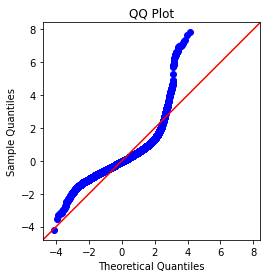

In [112]:
res_price = amen_price_model.resid

fig, ax = plt.subplots()
pplot = sm.ProbPlot(res_price)
pplot.qqplot(ax=ax)
sm.qqline(ax, '45')
plt.title('QQ Plot')
plt.gca().set_aspect('equal', adjustable='box');

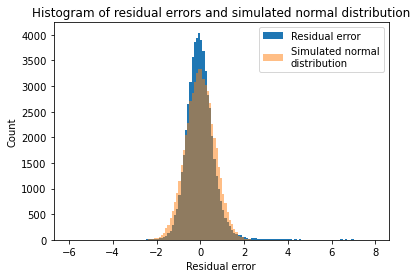

In [113]:
norm_price = np.random.normal(loc=np.mean(res_price), scale=np.std(res_price), size=len(res_price))

bins = np.arange(-6, 8, 0.1)
plt.hist(res_price, bins)
plt.hist(norm_price, bins, alpha=0.5)
plt.title('Histogram of residual errors and simulated normal distribution')
plt.legend(['Residual error', 'Simulated normal\ndistribution'])
plt.xlabel('Residual error')
plt.ylabel('Count');

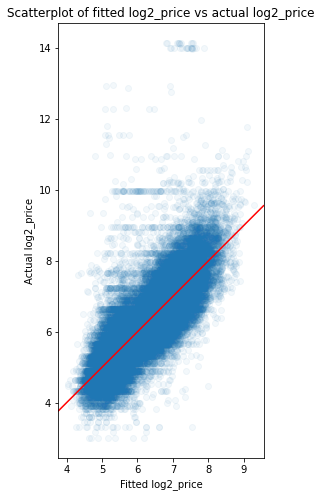

In [114]:
fit_price = amen_price_model.fittedvalues

plt.figure(figsize=(8,8))
plt.scatter(fit_price, listings['log2_price'], alpha=0.05)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'r', scalex=False, scaley=False)
plt.title('Scatterplot of fitted log2_price vs actual log2_price')
plt.xlabel('Fitted log2_price')
plt.ylabel('Actual log2_price')
plt.gca().set_aspect('equal', adjustable='box');

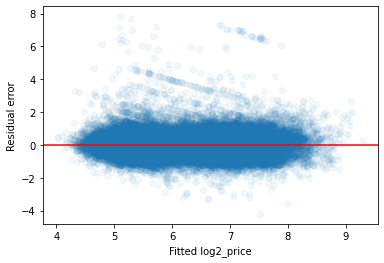

In [115]:
plt.scatter(fit_price, res_price, alpha=0.05)
xpoints = plt.xlim()
plt.plot(xpoints, [0, 0], 'r', scalex=False, scaley=False)
plt.xlabel('Fitted log2_price')
plt.ylabel('Residual error');

No real improvement. We check to see whether including amenities has made much difference to the modelled multiplicative effect of neighborhood on price.

In [116]:
# Get list of neighborhoods from previously stored variable
nbhs = neighborhood_counts.index.to_list()

# Remove westminster as this is the baseline case
nbhs.remove('westminster')

# Concatenate parameters from the two models into a dataframe
nbhs_df = pd.concat([price_model.params[nbhs], amen_price_model.params[nbhs]], axis=1)

# Transform additive effect on log2_price to multiplicative effect on price
nbhs_df = 2 ** nbhs_df

# Calculate the proportional change in modelled effect when including amenities
# (a transformed parameter of 1 means no effect)
nbhs_df.columns = ['price_model', 'amen_price_model']
nbhs_df['prop_change'] = (1 - nbhs_df['amen_price_model']) / (1 - nbhs_df['price_model']) 
nbhs_df

,price_model,amen_price_model,prop_change
tower_hamlets,0.681599,0.715265,0.894266
hackney,0.663401,0.708604,0.865705
camden,0.803069,0.839884,0.813056
kensington_and_chelsea,0.990590,0.987871,1.288961
islington,0.747865,0.782797,0.861458
lambeth,0.684777,0.724611,0.873633
southwark,0.703667,0.747717,0.851348
wandsworth,0.736783,0.767697,0.882554
hammersmith_and_fulham,0.778999,0.796282,0.921795
brent,0.663491,0.713754,0.850634


Including amenities in the model does reduce the modelled multiplicative effect of most neighborhoods on price.

We check for evidence of overfitting in the form of some amenities disproportionately affecting price.

In [117]:
# Get a list of parameters sorted by absolute magnitude of effect
sorted_abs_params = amen_price_model.params.abs().sort_values()

# Select from the top 50 any which aren't neighborhoods
non_neighborhood_features = [f for f in sorted_abs_params[-50:].index if f not in nbhs]

# Check the multiplicative effect of these features on price
(2 ** amen_price_model.params[non_neighborhood_features]).sort_values()

shared_room                 0.469965
private_room                0.577355
hotel_room                  0.806605
n_reviews_100_499           0.838571
has_table_corner_guards     0.846829
n_reviews_50_99             0.858692
n_reviews_500_999           0.867937
has_electric_stove          0.886132
has_fireplace               1.115076
has_tv                      1.127426
has_induction_stove         1.138416
has_dishwasher              1.155453
has_air_conditioning        1.203186
has_self_checkin            1.242928
accommodates_2_2            1.269042
accommodates_3_4            1.610081
accommodates_5_7            2.238003
accommodates_8_16           3.291522
const                      93.013526
dtype: float64

None of the amenities are disproportionately affecting price.

It seems it is worth keeping these amenities in the model, even though they don't help identify the most expensive listings.

### Price quantile regression model

The expensive listings do seem to be atypical in some sense, on the basis of the residual errors. While we could attempt to classify some subset of these listings as outliers, there is no clear boundary on which to base this classification.

Instead, we switch to a quantile regression, and estimate the median log2_price (the algorithm's default 0.5 quantile), rather than the mean log2_price. As well as the median's inherent robustness, this approach has the added advantage of enabling us to model other quantiles too, should we later decide to extend the analysis into a more detailed view across the spectrum of prices.

To obtain accurate p-values for the purpose of streamlining the model by stripping out features which don't appear to be significant, we will repeat the regression on 1000 bootstrapped samples.

First we build a dataframe of the parameters from 1000 bootstrap sample regressions. We then select the significant features (for which the 0.01 quantile and 0.99 quantile of its parameters are both on the same side of zero i.e. both positive or both negative).

In [118]:
"""# WARNING - THIS TAKES A FEW HOURS! UNCOMMENT TO RUN, OTHERWISE USE HARDCODED RESULTS BELOW

# Create dataframe to hold parameters for each sample
params = pd.DataFrame()

# Create checkin points for monitoring progress
checkins = [5, 10, 20, 50, 100, 250, 500, 750, 900, 950]

for i in range(0,1000):
    # Bootstrap data and run regression
    sample = listings.sample(frac=1, replace=True, random_state=101+i)
    qmod = sm.QuantReg(sample[y], sm.add_constant(sample[X])).fit(max_iter=2500)
    
    # Add parameters to dataframe
    params = pd.concat([params, qmod.params], axis=1)
    
    # Report progress if at checkin point
    if (i + 1) in checkins:
        print(f'{i + 1} samples complete')

# Determine which features are significant
significant = ((params.quantile(0.01, axis=1) > 0) == (params.quantile(0.99, axis=1) > 0)) & \
              (params.quantile(0.01, axis=1) != 0) & \
              (params.quantile(0.99, axis=1) != 0)

# Redefine X to only include column names for significant features
X = significant[significant == True].index.tolist()

# Remove reference to temporary const column
X.remove('const')
X
"""

"# WARNING - THIS TAKES A FEW HOURS! UNCOMMENT TO RUN, OTHERWISE USE HARDCODED RESULTS BELOW\n\n# Create dataframe to hold parameters for each sample\nparams = pd.DataFrame()\n\n# Create checkin points for monitoring progress\ncheckins = [5, 10, 20, 50, 100, 250, 500, 750, 900, 950]\n\nfor i in range(0,1000):\n    # Bootstrap data and run regression\n    sample = listings.sample(frac=1, replace=True, random_state=101+i)\n    qmod = sm.QuantReg(sample[y], sm.add_constant(sample[X])).fit(max_iter=2500)\n    \n    # Add parameters to dataframe\n    params = pd.concat([params, qmod.params], axis=1)\n    \n    # Report progress if at checkin point\n    if (i + 1) in checkins:\n        print(f'{i + 1} samples complete')\n\n# Determine which features are significant\nsignificant = ((params.quantile(0.01, axis=1) > 0) == (params.quantile(0.99, axis=1) > 0)) &               (params.quantile(0.01, axis=1) != 0) &               (params.quantile(0.99, axis=1) != 0)\n\n# Redefine X to only include 

In [119]:
# These are the hardcoded results from the 1000 bootstrapped regressions above.
# Comment out if running fresh bootstrapped regressions.
X = [
 'host_is_superhost',
 'instant_bookable',
 'responds_a_few_days_or_more',
 'responds_within_a_day',
 'barking_and_dagenham',
 'barnet',
 'bexley',
 'brent',
 'bromley',
 'camden',
 'city_of_london',
 'croydon',
 'ealing',
 'enfield',
 'greenwich',
 'hackney',
 'hammersmith_and_fulham',
 'haringey',
 'harrow',
 'havering',
 'hillingdon',
 'hounslow',
 'islington',
 'kingston_upon_thames',
 'lambeth',
 'lewisham',
 'merton',
 'newham',
 'redbridge',
 'richmond_upon_thames',
 'southwark',
 'sutton',
 'tower_hamlets',
 'waltham_forest',
 'wandsworth',
 'hotel_room',
 'private_room',
 'shared_room',
 'accommodates_2_2',
 'accommodates_3_4',
 'accommodates_5_7',
 'accommodates_8_16',
 'min_nights_3_7',
 'min_nights_8_31',
 'min_nights_32_90',
 'max_nights_8_31',
 'n_reviews_2_4',
 'n_reviews_5_9',
 'n_reviews_10_49',
 'n_reviews_50_99',
 'n_reviews_100_499',
 'score_20_87',
 'score_88_90',
 'score_91_92',
 'score_93_93',
 'score_98_98',
 'score_99_99',
 'score_100_100',
 'has_essentials',
 'has_kitchen',
 'has_smoke_alarm',
 'has_washer',
 'has_dryer',
 'has_iron',
 'has_tv',
 'has_shampoo',
 'has_office',
 'has_hot_water',
 'has_carbon_monoxide_alarm',
 'has_refrigerator',
 'has_oven',
 'has_bed_linens',
 'has_microwave',
 'has_fire_extinguisher',
 'has_dishwasher',
 'has_free_parking',
 'has_coffee_maker',
 'has_long_term_stays_allowed',
 'has_private_entrance',
 'has_elevator',
 'has_paid_parking',
 'has_host_greets_you',
 'has_balcony',
 'has_cable',
 'has_lock_on_bedroom_door',
 'has_safe',
 'has_fireplace',
 'has_shower',
 'has_single_level_home',
 'has_air_conditioning',
 'has_roomdarkening_shades',
 'has_cleaning_before_checkout',
 'has_gym',
 'has_video_games',
 'has_self_checkin',
 'has_bread_maker',
 'has_table_corner_guards',
 'has_kettle'
]

We note that not all neighborhoods are necessarily included in the list of features above, because some may not be significantly different to Westminster in terms of median price.

We run the quantile regression for the streamlined price model.

In [120]:
streamlined_price_qmodel = sm.QuantReg(listings[y], sm.add_constant(listings[X])).fit()

In [121]:
print(streamlined_price_qmodel.summary())

                         QuantReg Regression Results                          
Dep. Variable:             log2_price   Pseudo R-squared:               0.4590
Model:                       QuantReg   Bandwidth:                     0.06990
Method:                 Least Squares   Sparsity:                        1.344
Date:                Fri, 09 Jul 2021   No. Observations:                54704
Time:                        12:16:04   Df Residuals:                    54605
                                        Df Model:                           98
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            6.4206      0.025    257.680      0.000       6.372       6.469
host_is_superhost                0.0289      0.009      3.374      0.001       0.012       0.046
instant_bookable                -0.0295      0.006     -4.6

We transform the parameters for the neighbourhoods to discover their multiplicative effect on price.

In [122]:
# Establish which neighborhood were included in/excluded from the model
nbhs = neighborhood_counts.index.to_list()
nbhs_inc = [n for n in nbhs if n in X]
nbhs_exc = [n for n in nbhs if n not in X]

# Create series of transformed parameters for neighborhoods included in the model
q1 = (2 ** streamlined_price_qmodel.params[nbhs_inc])

# Create series of transformed parameters for neighborhoods excluded from the model
q1_exc = pd.Series({nbh: 1 for nbh in nbhs_exc})

# Combine and sort
q1 = q1.append(q1_exc).sort_values()

q1

barking_and_dagenham      0.542002
havering                  0.570022
croydon                   0.572045
waltham_forest            0.572777
bexley                    0.579233
redbridge                 0.583987
bromley                   0.590032
sutton                    0.604495
lewisham                  0.613489
hillingdon                0.626007
greenwich                 0.631569
enfield                   0.631871
newham                    0.637934
haringey                  0.640588
barnet                    0.665786
kingston_upon_thames      0.665962
harrow                    0.676851
ealing                    0.677914
brent                     0.701475
hounslow                  0.712289
hackney                   0.715369
tower_hamlets             0.722663
merton                    0.728919
lambeth                   0.731799
southwark                 0.754787
wandsworth                0.780231
islington                 0.790980
hammersmith_and_fulham    0.805027
richmond_upon_thames

This provides our answer to question 1.

### Reviews per month quantile regression model

We stick with quantile regression for consistency.

We define X and y for the reviews per month regression. Here, we will not include `number_of_reviews`,  because `reviews_per_month` is derived from a close relative of `number_of_reviews`.

In [123]:
listings.drop(['n_reviews_2_4',
               'n_reviews_5_9',
               'n_reviews_10_49',
               'n_reviews_50_99',
               'n_reviews_100_499',
               'n_reviews_500_999'], axis=1, inplace=True)
X = listings.columns[:-2].tolist()
y = listings.columns[-1]

To obtain accurate p-values for the purpose of streamlining the model by stripping out features which don't appear to be significant, we will repeat the regression on 1000 bootstrapped samples as before.

In [124]:
"""
# WARNING - THIS TAKES A FEW HOURS! UNCOMMENT TO RUN, OTHERWISE USE HARDCODED RESULTS BELOW

# Create dataframe to hold parameters for each sample
params = pd.DataFrame()

# Create checkin points for monitoring progress
checkins = [5, 10, 20, 50, 100, 250, 500, 750, 900, 950]

for i in range(0,1000):
    # Bootstrap data and run regression
    sample = listings.sample(frac=1, replace=True, random_state=101+i)
    qmod = sm.QuantReg(sample[y], sm.add_constant(sample[X])).fit(max_iter=5000)
    
    # Add parameters to dataframe
    params = pd.concat([params, qmod.params], axis=1)
    
    # Report progress if at checkin point
    if (i + 1) in checkins:
        print(f'{i + 1} samples complete')

# Determine which features are significant
significant = ((params.quantile(0.01, axis=1) > 0) == (params.quantile(0.99, axis=1) > 0)) & \
              (params.quantile(0.01, axis=1) != 0) & \
              (params.quantile(0.99, axis=1) != 0)

# Redefine X to only include column names for significant features
X = significant[significant == True].index.tolist()

# Remove reference to temporary const column
X.remove('const')
X
"""

"\n# WARNING - THIS TAKES A FEW HOURS! UNCOMMENT TO RUN, OTHERWISE USE HARDCODED RESULTS BELOW\n\n# Create dataframe to hold parameters for each sample\nparams = pd.DataFrame()\n\n# Create checkin points for monitoring progress\ncheckins = [5, 10, 20, 50, 100, 250, 500, 750, 900, 950]\n\nfor i in range(0,1000):\n    # Bootstrap data and run regression\n    sample = listings.sample(frac=1, replace=True, random_state=101+i)\n    qmod = sm.QuantReg(sample[y], sm.add_constant(sample[X])).fit(max_iter=5000)\n    \n    # Add parameters to dataframe\n    params = pd.concat([params, qmod.params], axis=1)\n    \n    # Report progress if at checkin point\n    if (i + 1) in checkins:\n        print(f'{i + 1} samples complete')\n\n# Determine which features are significant\nsignificant = ((params.quantile(0.01, axis=1) > 0) == (params.quantile(0.99, axis=1) > 0)) &               (params.quantile(0.01, axis=1) != 0) &               (params.quantile(0.99, axis=1) != 0)\n\n# Redefine X to only includ

In [125]:
# These are the hardcoded results from the 1000 bootstrapped regressions above.
# Comment out if running fresh bootstrapped regressions.
X = [
 'host_is_superhost',
 'instant_bookable',
 'responds_a_few_days_or_more',
 'responds_within_a_day',
 'responds_within_a_few_hours',
 'responds_within_an_hour',
 'barking_and_dagenham',
 'barnet',
 'bexley',
 'brent',
 'croydon',
 'ealing',
 'enfield',
 'greenwich',
 'hackney',
 'hammersmith_and_fulham',
 'haringey',
 'harrow',
 'havering',
 'hounslow',
 'islington',
 'kensington_and_chelsea',
 'kingston_upon_thames',
 'lambeth',
 'lewisham',
 'merton',
 'newham',
 'redbridge',
 'richmond_upon_thames',
 'southwark',
 'sutton',
 'tower_hamlets',
 'waltham_forest',
 'wandsworth',
 'hotel_room',
 'accommodates_2_2',
 'accommodates_3_4',
 'min_nights_2_2',
 'min_nights_3_7',
 'min_nights_8_31',
 'min_nights_32_90',
 'max_nights_3_7',
 'score_20_87',
 'score_88_90',
 'score_91_92',
 'score_93_93',
 'score_94_95',
 'score_97_97',
 'score_98_98',
 'score_99_99',
 'score_100_100',
 'has_wifi',
 'has_essentials',
 'has_heating',
 'has_kitchen',
 'has_smoke_alarm',
 'has_washer',
 'has_hangers',
 'has_iron',
 'has_hair_dryer',
 'has_hot_water',
 'has_carbon_monoxide_alarm',
 'has_refrigerator',
 'has_bed_linens',
 'has_microwave',
 'has_first_aid_kit',
 'has_dishwasher',
 'has_coffee_maker',
 'has_long_term_stays_allowed',
 'has_private_entrance',
 'has_elevator',
 'has_host_greets_you',
 'has_balcony',
 'has_cable',
 'has_lock_on_bedroom_door',
 'has_safe',
 'has_fireplace',
 'has_shower',
 'has_single_level_home',
 'has_air_conditioning',
 'has_high_chair',
 'has_toys',
 'has_ethernet',
 'has_roomdarkening_shades',
 'has_barbeque',
 'has_hot_tub',
 'has_freezer',
 'has_keypad',
 'has_smart_lock',
 'has_self_checkin',
 'has_mini_fridge',
 'has_bluetooth',
 'has_pets_allowed']

We run the quantile regression for the streamlined reviews per month model.

In [126]:
rpm_model = sm.QuantReg(listings[y], sm.add_constant(listings[X])).fit()

We look at the summary results and some diagnostic charts.

In [127]:
print(rpm_model.summary())

                           QuantReg Regression Results                            
Dep. Variable:     log2_reviews_per_month   Pseudo R-squared:               0.3146
Model:                           QuantReg   Bandwidth:                      0.1748
Method:                     Least Squares   Sparsity:                        3.363
Date:                    Fri, 09 Jul 2021   No. Observations:                54704
Time:                            12:16:17   Df Residuals:                    54610
                                            Df Model:                           93
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -3.6002      0.069    -51.987      0.000      -3.736      -3.465
host_is_superhost               0.6157      0.022     28.622      0.000       0.574       0.658
instant_bookable                0.2

We transform the parameters for the neighbourhoods to discover their multiplicative effect on reviews per month.

In [128]:
# Establish which neighborhood were included in/excluded from the model
nbhs = neighborhood_counts.index.to_list()
nbhs_inc = [n for n in nbhs if n in X]
nbhs_exc = [n for n in nbhs if n not in X]

# Create series of transformed parameters for neighborhoods included in the model
q2 = (2 ** rpm_model.params[nbhs_inc])

# Create series of transformed parameters for neighborhoods excluded from the model
q2_exc = pd.Series({nbh: 1 for nbh in nbhs_exc})

# Combine and sort
q2 = q2.append(q2_exc).sort_values()

q2

redbridge                 0.671571
enfield                   0.681821
havering                  0.702593
kingston_upon_thames      0.717945
merton                    0.719388
barnet                    0.719985
sutton                    0.732203
bexley                    0.737194
harrow                    0.737854
barking_and_dagenham      0.750920
ealing                    0.789016
lewisham                  0.802619
richmond_upon_thames      0.811408
hackney                   0.811793
haringey                  0.812715
wandsworth                0.820667
waltham_forest            0.823215
brent                     0.824939
greenwich                 0.830998
hounslow                  0.841165
newham                    0.852768
hammersmith_and_fulham    0.864246
croydon                   0.866912
tower_hamlets             0.906394
islington                 0.908573
lambeth                   0.909860
kensington_and_chelsea    0.925388
southwark                 0.931978
westminster         

This provides our answer to question 2.

Lastly, we transform the parameters for the top 5 features aside from neighborhood, to discover their multiplicative effect on reviews per month.

In [129]:
sorted_abs_params = rpm_model.params.abs().sort_values()
sorted_abs_params[-25:]

barnet                         0.473961
merton                         0.475158
kingston_upon_thames           0.478056
score_93_93                    0.490036
havering                       0.509238
responds_a_few_days_or_more    0.520711
has_bluetooth                  0.523996
enfield                        0.552535
has_smart_lock                 0.553254
redbridge                      0.574388
host_is_superhost              0.615680
has_pets_allowed               0.616056
min_nights_8_31                0.620288
hotel_room                     0.644249
responds_within_a_day          0.703478
score_100_100                  0.704704
score_98_98                    0.774609
responds_within_a_few_hours    0.812092
score_97_97                    0.834890
score_94_95                    0.842463
responds_within_an_hour        0.914510
score_91_92                    0.916993
score_99_99                    1.063283
has_self_checkin               1.284821
const                          3.600245


We ignore `const`, and `hotel_room` (as this can't be changed or influenced), and include all options for binned features within the 5 most extreme e.g. score, response speed, min nights.

In [130]:
# List of 5 most extreme features
non_neighborhood_features = [f for f in sorted_abs_params[-14:-1].index]
non_neighborhood_features.remove('hotel_room')

# List of other options for binned features (if option included in model)
other_options = ['score_20_87', 
                 'score_88_90', 
                 'score_93_93',
                 'responds_a_few_days_or_more',
                 'min_nights_2_2',
                 'min_nights_3_7',
                 'min_nights_32_90',
                 'min_nights_91_1999']
other_options = [o for o in other_options if o in X]

# Combine lists
non_neighborhood_features += other_options

# Transform
q3 = (2 ** rpm_model.params[non_neighborhood_features]).sort_values()
q3

score_100_100                  0.613569
min_nights_8_31                0.650541
min_nights_3_7                 0.722141
min_nights_32_90               0.761354
score_20_87                    0.812959
min_nights_2_2                 0.952913
score_88_90                    1.318321
score_93_93                    1.404480
responds_a_few_days_or_more    1.434662
has_pets_allowed               1.532679
responds_within_a_day          1.628425
score_98_98                    1.710727
responds_within_a_few_hours    1.755755
score_97_97                    1.783721
score_94_95                    1.793109
responds_within_an_hour        1.884929
score_91_92                    1.888175
score_99_99                    2.089681
has_self_checkin               2.436517
dtype: float64

This provides our answer to question 3.

## Results

### 1. How do the different neighborhoods typically compare in price?

We take a visual look at the results.

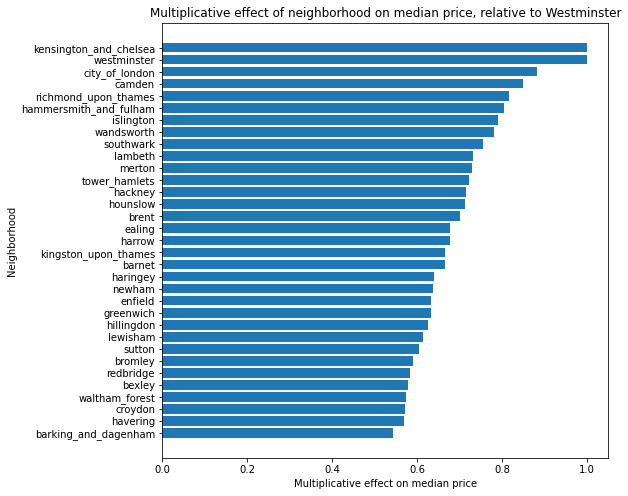

In [131]:
plt.figure(figsize=(8,8))
plt.barh(q1.index, q1)
plt.title('Multiplicative effect of neighborhood on median price, relative to Westminster')
plt.xlabel('Multiplicative effect on median price')
plt.ylabel('Neighborhood');

Neighborhood does affect median listing price, with the cheapest (Barking & Dagenham) being just over half as expensive as the most expensive (Westminster and Kensington & Chelsea).

### 2. How do the different neighborhoods typically compare in number of reviews per month?

We take a visual look at the results.

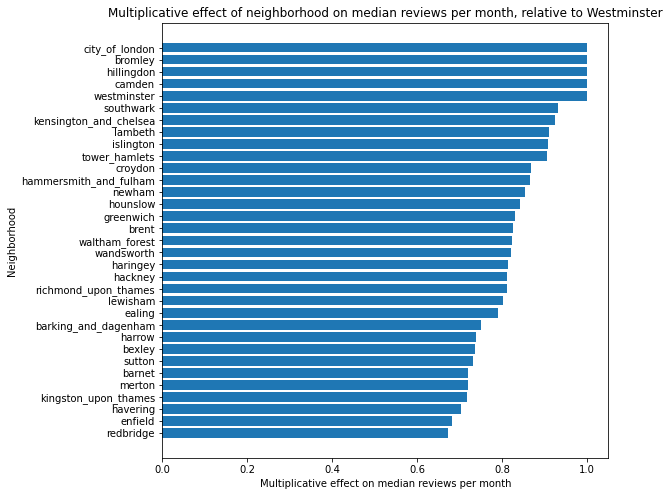

In [132]:
plt.figure(figsize=(8,8))
plt.barh(q2.index, q2)
plt.title('Multiplicative effect of neighborhood on median reviews per month, relative to Westminster')
plt.xlabel('Multiplicative effect on median reviews per month')
plt.ylabel('Neighborhood');

Neighborhood does affect median listing reviews per month, with the quietest (Redbridge), being about a third as busy as the busiest (Westminster, Camden, Hillingdon, Bromley, City of London).

### 3. What else is typically important for getting more reviews per month (i.e. the top 5 influential factors)?

We take a visual look at the results.

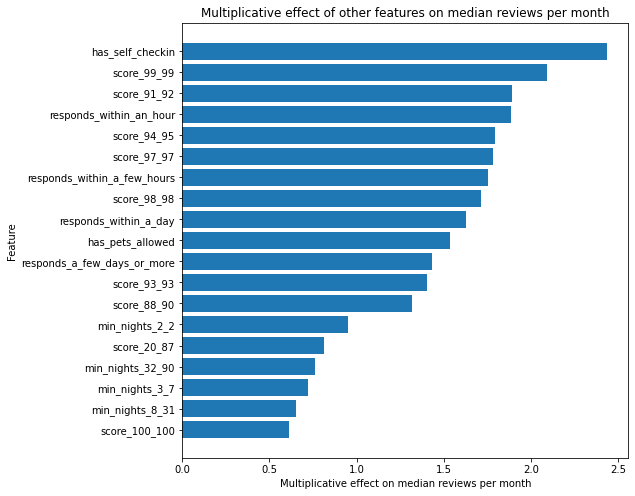

In [133]:
plt.figure(figsize=(8,8))
plt.barh(q3.index, q3)
plt.title('Multiplicative effect of other features on median reviews per month')
plt.xlabel('Multiplicative effect on median reviews per month')
plt.ylabel('Feature');

#### Average review score

The most influential factor on reviews per month is average review score. Listings with an average review score of 99% have a median reviews per month 3.41 times greater than those with an average review score of 100% (`2.089681 / 0.613569`).

But this seems counter-intuitive. Perhaps it is because an average score of 100% often indicates only a small number of reviews, with the average yet to be pulled down by the occasional sub-par review. In a sense, a low number of reviews could be an influential factor in an average score of 100% moreso than the reverse.

We check.

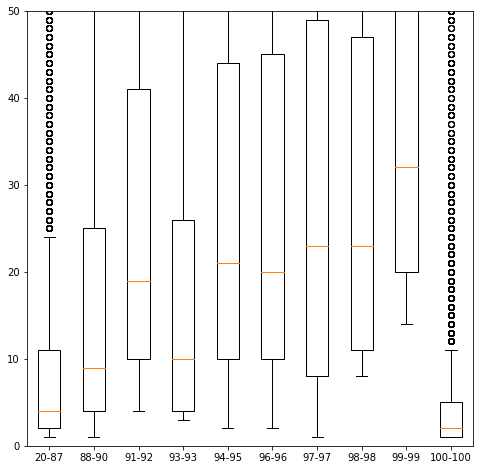

In [134]:
listings = pd.read_csv('listings.csv')

# Bin review score
bins = [s - 1 for s in score_deciles] # needed as bins will applied as (x, y]
listings['reviews'] = pd.cut(listings['review_scores_rating'],
                             bins,
                             labels = [str(b) for b in bins[1:]])

# Prepare data for side-by-side boxplots
score_data = [listings[listings['reviews'] == str(b)]['number_of_reviews'] for b in bins[1:]]

# Plot data
plt.figure(figsize=(8,8))
plt.boxplot(score_data)
plt.ylim(0,50)
xticks = [f'{bins[i]+1}-{bins[i+1]}' for i in range(0,len(bins)-1)]
plt.xticks(list(range(1,11)), xticks);

It turns out that average review scores of 100% are indeed correlated with very low numbers of reviews - most often they are an average of just one or two reviews. With more reviews, these listings would likely have their average review score pulled down by the occasional imperfect experience or strict reviewer.

This being the case it makes sense to disregard the apparent effect of an average review score of 100%.

Another oddity of the effect of average review score is that the baseline 96% correlates with a much lower median number of reviews per month than 88%-95% or 97%-99%. There is no apparent explanation for this.

That aside, listings with an average review score of 99% have median reviews per month 2.57 times greater than those with an average review score of 20%-87% (`2.089681 / 0.812959`).

#### Minimum Nights

Listings with no minimum nights have median reviews per month 1.54 times greater than those with 8-31 minimum nights (`1 / 0.650541`).

#### Response Time

Given that all response times improve median reviews per month, it's possible that the baseline includes "no response" as well as "untested". Alternatively, it could be that enquiries are commonly made when booking listings, so "untested" correlates highly with unpopular listings by its nature.

#### Final comparative

We take a visual look at the maximum multiplicative effect of the top 5 influential features for getting more reviews per month.

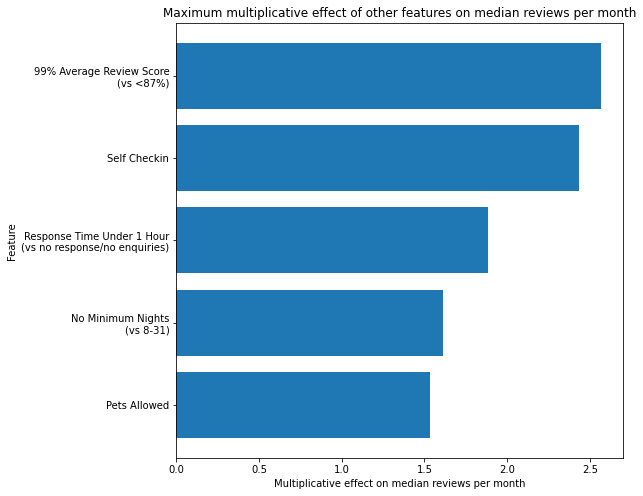

In [135]:
influential_features = pd.Series({'Pets Allowed':1.532679,
                                  'No Minimum Nights\n(vs 8-31)':1.611497,
                                  'Response Time Under 1 Hour\n(vs no response/no enquiries)':1.884929,
                                  'Self Checkin':2.436517,
                                  '99% Average Review Score\n(vs <87%)':2.570463})

plt.figure(figsize=(8,8))
plt.barh(influential_features.index, influential_features)
plt.title('Maximum multiplicative effect of other features on median reviews per month')
plt.xlabel('Multiplicative effect on median reviews per month')
plt.ylabel('Feature');

The five most important factors for getting more reviews per month are average review score, self checkin, response time to enquiries, minimum nights, and pets being allowed.

## Conclusions

Neighborhood does affect median listing price, with the cheapest (Barking & Dagenham) being just over half as expensive as the most expensive (Westminster and Kensington & Chelsea).

Neighborhood does affect median listing reviews per month, with the quietest (Redbridge), being about a third as busy as the busiest (Westminster, Camden, Hillingdon, Bromley, City of London).

The five most important factors for getting more reviews per month are average review score, self checkin, response time to enquiries, minimum nights, and pets being allowed.

## Data sources and references

* Airbnb data is provided by Inside Airbnb (http://insideairbnb.com/get-the-data.html).